### Loading packages

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import time
import warnings
import os

In [2]:
# set seed to control sources of randomness for reproducibilty
np.random.seed(10);   
torch.manual_seed(0);

### Discretized example problem

In [3]:
import OCP

# name problem
problem_type = 'BilinCtrlZeroTarget'

# choose dimension
n = 20

# choose reaction term
#rxn = None
rxn = 'hyperbolic'
#rxn = 'logistic'

# choose control term
#ctrl=None
#ctrl = 'add'
ctrl = 'bilin'

# choose indicator function for additive control
#ind_fun = (0.25, 0.5)
#ind_fun = (0.25, 0.75)

# choose target
target = OCP.zero
#target = OCP.quadratic
#target = OCP.polynomial
#target = OCP.sin   
#target = OCP.quadratic_cos

# choose coefficients for system and cost
system_coeff = {'a':0.02, 'b':1., 'c':1.}
cost_coeff = {'alpha':1., 'beta':0.1, 'gamma':2.}

# choose initial and final time, 1D space and initial condition domain
#t=(0.,5.)
#Omega=(0.,1.)
#X0=(-1.5,1.5))

# initialize problem
problem = OCP.ControlledReactionDiffusionSystem(n, rxn=rxn, ctrl=ctrl, target=target, 
                                                system_coeff=system_coeff, cost_coeff=cost_coeff)

# save problem and its configurations
problem.save_config(problem_type)
problem.save_problem(problem_type)

### Initial data generation

In [4]:
import BVP
import data_generation

# choose number of trajectories in initial training set and validation set
num_train_samples = 5 
num_val_samples = 5

# choose time-marching sequence
init_config = {'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}

# generate initial training data using time-marching
X0_samples = data_generation.sample_X0(problem, num_samples=num_train_samples)
print('------------------------------------\n Initial Training Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                                                       init_config=init_config)
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'train')

# generate validation data using time-marching
X0_samples = data_generation.sample_X0(problem, num_samples=num_val_samples)
print('------------------------------------\n Validation Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                                                       init_config=init_config)
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'val')

------------------------------------
 Initial Training Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 5 generating 780 data points (from 737 initially guessed points)
solution time:       5.337371 of which 0.936511 solving BVP
solution time per data point: 0.006843

------------------------------------
 Validation Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 5 generating 790 data points (from 755 initially guessed points)
solution time:       5.274533 of which 0.923999 solving BVP
solution time per data point: 0.006677



### Neural network model

In [5]:
import NN

# name model
model_type = 'ResidualForcedFinalConditionNet'

# set hyperparameters
depth = 4
width = 100

#activation = nn.Tanh()        
#activation = nn.ReLU()         
activation = nn.Softplus()

#architecture = 'feedforward'  
architecture = 'residual'

# get cpu or gpu device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device\n')

# initialize model
#model = NN.FeedforwardNet(n, depth, width, activation, device).to(device)
model = NN.NeuralNet(n, depth, width, activation, architecture, device).to(device)
model = NN.ForcedFinalConditionNet(model, problem)

# print model and its parameters
print('------------------------------------\n Neural Network Model\n------------------------------------')
print(model)

using cpu device

------------------------------------
 Neural Network Model
------------------------------------
ForcedFinalConditionNet(
  (model): NeuralNet(
    (activation): Softplus(beta=1, threshold=20)
    (input_layer): Linear(in_features=21, out_features=100, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
    )
    (output_layer): Linear(in_features=100, out_features=1, bias=True)
  )
  (activation): Softplus(beta=1, threshold=20)
)


### Training with adaptive data generation

In [6]:
import NN_optimization

# name training
train_type = 'Adam'

# initialize optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
#optimizer = torch.optim.LBFGS(model.parameters())

# choose batch size
batch_size = 100
#batch_size = 'full'

# choose gradient regularization weight
#grad_reg = 0.
grad_reg = 100.

# choose early stopping, data set size selection and convergence parameters
#criterion = 'GL' 
criterion = 'PQ'
#criterion = 'UP'
error_metric = [0., 0., 1.]
#error_metric = [1., grad_reg, 0.]
stop_params = {'error_metric':error_metric, 'strip':5, 'num_strips':1, 
               'max_iter':50, 'min_progress':0.01, 'criterion':criterion, 'stop_tol':0.1}
select_params = {'subset_size':None, 'conv_tol':1e-4, 'growth_ub':1.25}
max_epoch = 200
max_time = 1000.

# save partially trained models
#partial_train_times = [float('inf')]
partial_train_times = [5, 100, float('inf')] 
current_train_phase = 0
partial_train_type = train_type + 'PartialTrain' + str(partial_train_times[current_train_phase])

# initialize training and convergence
training = NN_optimization.NetTraining(optimizer, batch_size, grad_reg=grad_reg, 
                                       max_epoch=max_epoch, max_time=max_time,
                                       stop_params=stop_params, select_params=select_params)

# save model configurations
model.save_config(problem_type, model_type, train_type)

# save training configurations
training.save_config(problem_type, model_type, train_type)

In [7]:
start_train_time = time.time()

# loop for convergence test and data generation
while True:
    # create data set
    train_data = data_generation.OCPDataset(problem_type, 'train')
    val_data = data_generation.OCPDataset(problem_type, 'val')

    # create dataloader
    if training.batch_size == 'full':
        train_dataloader = DataLoader(train_data, batch_size=len(train_data))
        val_dataloader = DataLoader(val_data, batch_size=len(val_data))    
    else:
        train_dataloader = DataLoader(train_data, batch_size=training.batch_size, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=training.batch_size, shuffle=True)

    # loop for training with fixed data set
    while True:
        training.current_epoch += 1
        print(f'------------------------------------\n Epoch {training.current_epoch}\n------------------------------------')
        
        # track number of training data
        num_train_data = len(train_data)
        training.num_train_data.append(num_train_data)
        
        # train model
        training.train(train_dataloader, model)
        print('')
        
        # compute relative errors
        print('training errors:')
        training.train_errors = np.hstack((training.train_errors, training.validate(train_dataloader, problem, model)))
        print('validation errors:')
        training.val_errors = np.hstack((training.val_errors, training.validate(val_dataloader, problem, model)))
        print('')
        
        # update optimal epoch and check early stopping criterion to prevent overfitting
        stop = training.early_stop()
        print('')
        
        # save model parameters of optimal epoch
        if training.opt_epoch == training.current_epoch:
            model.save_model(problem_type, model_type, train_type) 
        
        # track training time
        end_train_time = time.time()
        training.train_times.append(end_train_time - start_train_time)
        start_train_time = time.time()
        
        # save partially trained model
        if sum(training.train_times) >= partial_train_times[current_train_phase]:
            partial_train_model = NN.load_model(problem_type, model_type, train_type)
            partial_train_model.save_model(problem_type, model_type, partial_train_type) 
            current_train_phase += 1
            partial_train_type = train_type + 'PartialTrain' + str(partial_train_times[current_train_phase])
        
        # stop iterations
        if stop or training.current_epoch >= training.max_epoch or sum(training.train_times) >= training.max_time:
            training.stop_epochs.append(training.current_epoch)
            break
    
    if training.current_epoch >= training.max_epoch:
        print('Training terminated: maximum number of epochs is exceeded')
        break
        
    if sum(training.train_times) >= training.max_time:
        print('Training terminated: maximum time limit is exceeded')
        break
    
    # compute adaptive subset size for approximation of convergence criterion
    training.select_params['subset_size'] = int(100 * np.log(num_train_data/100 + 1))
    
    # select data set size
    new_num_train_data = training.select_dataset_size(train_data, model)
    training.generation_ratios.append(new_num_train_data/num_train_data)
    
    if new_num_train_data == num_train_data:
        print('Training terminated: convergence criterion is satisfied')
        break

    # generate data adaptively
    print('------------------------------------\n Adaptive Data Generation\n------------------------------------')
    # reset Adam
    #training.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
    while new_num_train_data > num_train_data and (sum(training.train_times) + time.time() - start_train_time) < training.max_time:
        # sample and select initial conditions with largest gradient norm
        X0_candidates = data_generation.sample_X0(problem, num_samples=10)
        X0_sample = data_generation.select_X0(problem, model, X0_candidates, num_top=1)
        
        # solve BVP with NN warm start
        solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
        t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_sample, initialization='NN_warm_start', 
                                                           init_config={'model':model}, solver_config=solver_config)
        # track number of generated data
        num_train_data += len(t_data)
        print(f'data generated: {num_train_data} / {new_num_train_data} \n')
        
        # add new data to saved data
        data_generation.update_data(t_data, X_aug_data, idx_samples, problem_type, 'train')
    
    if (sum(training.train_times) + time.time() - start_train_time) >= max_time:
        print('Training terminated: maximum time limit is exceeded')
        break

end_train_time = time.time()
training.train_times.append(end_train_time - start_train_time)
        
# save training instance
training.save_training(problem_type, model_type, train_type)

------------------------------------
 Epoch 1
------------------------------------
total loss: 7.829247, value loss: 0.446303, grad loss: 0.073829 [    0/  780]

training errors:
value RMAE: 5.727000, grad RML1: 2.565898, ctrl RMAE: 5.884314
validation errors:
value RMAE: 5.301507, grad RML1: 3.831228, ctrl RMAE: 7.447143

generalization loss: 0.000000

------------------------------------
 Epoch 2
------------------------------------
total loss: 7.001052, value loss: 0.060364, grad loss: 0.069407 [    0/  780]

training errors:
value RMAE: 4.419061, grad RML1: 2.495322, ctrl RMAE: 5.804706
validation errors:
value RMAE: 4.853790, grad RML1: 3.717373, ctrl RMAE: 7.491941

generalization loss: 0.006016

------------------------------------
 Epoch 3
------------------------------------
total loss: 5.072615, value loss: 0.038147, grad loss: 0.050345 [    0/  780]

training errors:
value RMAE: 4.571922, grad RML1: 2.461203, ctrl RMAE: 5.731670
validation errors:
value RMAE: 4.657376, grad 

value RMAE: 4.768594, grad RML1: 0.711657, ctrl RMAE: 0.606552
validation errors:
value RMAE: 5.444276, grad RML1: 1.977784, ctrl RMAE: 3.330972

generalization loss: 0.000000
training progress:   0.456527

------------------------------------
 Epoch 22
------------------------------------
total loss: 0.984017, value loss: 0.092133, grad loss: 0.008919 [    0/ 1142]
total loss: 0.446422, value loss: 0.078332, grad loss: 0.003681 [ 1000/ 1142]

training errors:
value RMAE: 8.374891, grad RML1: 0.628871, ctrl RMAE: 0.413344
validation errors:
value RMAE: 6.560992, grad RML1: 1.941834, ctrl RMAE: 3.288678

generalization loss: 0.000000
training progress:   0.602642

------------------------------------
 Epoch 23
------------------------------------
total loss: 0.492690, value loss: 0.126079, grad loss: 0.003666 [    0/ 1142]
total loss: 0.461191, value loss: 0.095190, grad loss: 0.003660 [ 1000/ 1142]

training errors:
value RMAE: 9.609073, grad RML1: 0.616615, ctrl RMAE: 0.478072
validat

total loss: 0.113219, value loss: 0.010401, grad loss: 0.001028 [ 1000/ 1142]

training errors:
value RMAE: 3.865324, grad RML1: 0.368000, ctrl RMAE: 0.209706
validation errors:
value RMAE: 6.410491, grad RML1: 1.706663, ctrl RMAE: 2.932396

generalization loss: 0.000000
training progress:   0.066957

------------------------------------
 Epoch 41
------------------------------------
total loss: 0.121065, value loss: 0.027884, grad loss: 0.000932 [    0/ 1142]
total loss: 0.141120, value loss: 0.008599, grad loss: 0.001325 [ 1000/ 1142]

training errors:
value RMAE: 2.320889, grad RML1: 0.357628, ctrl RMAE: 0.193753
validation errors:
value RMAE: 2.341063, grad RML1: 1.682669, ctrl RMAE: 2.834837

generalization loss: 0.000000
training progress:   0.100714

------------------------------------
 Epoch 42
------------------------------------
total loss: 0.127041, value loss: 0.014118, grad loss: 0.001129 [    0/ 1142]
total loss: 0.132933, value loss: 0.025752, grad loss: 0.001072 [ 1000

total loss: 0.250756, value loss: 0.005304, grad loss: 0.002455 [    0/ 2046]
total loss: 0.165684, value loss: 0.007087, grad loss: 0.001586 [ 1000/ 2046]
total loss: 0.107281, value loss: 0.003001, grad loss: 0.001043 [ 2000/ 2046]

training errors:
value RMAE: 1.067494, grad RML1: 0.390655, ctrl RMAE: 0.266183
validation errors:
value RMAE: 2.157737, grad RML1: 1.040994, ctrl RMAE: 1.507382

generalization loss: 0.000000
training progress:   0.348343

------------------------------------
 Epoch 55
------------------------------------
total loss: 0.165943, value loss: 0.003090, grad loss: 0.001629 [    0/ 2046]
total loss: 0.150239, value loss: 0.002642, grad loss: 0.001476 [ 1000/ 2046]
total loss: 0.296702, value loss: 0.002447, grad loss: 0.002943 [ 2000/ 2046]

training errors:
value RMAE: 1.216294, grad RML1: 0.427522, ctrl RMAE: 0.313646
validation errors:
value RMAE: 2.323378, grad RML1: 1.085464, ctrl RMAE: 1.468404

generalization loss: 0.000000
training progress:   0.205049

total loss: 0.093542, value loss: 0.015317, grad loss: 0.000782 [ 1000/ 2588]
total loss: 0.078228, value loss: 0.001219, grad loss: 0.000770 [ 2000/ 2588]

training errors:
value RMAE: 0.720648, grad RML1: 0.320935, ctrl RMAE: 0.199969
validation errors:
value RMAE: 0.648837, grad RML1: 0.701223, ctrl RMAE: 0.862051

generalization loss: 0.000000
training progress:   0.193731

------------------------------------
 Epoch 69
------------------------------------
total loss: 0.087338, value loss: 0.001101, grad loss: 0.000862 [    0/ 2588]
total loss: 0.109432, value loss: 0.000578, grad loss: 0.001089 [ 1000/ 2588]
total loss: 0.076473, value loss: 0.004651, grad loss: 0.000718 [ 2000/ 2588]

training errors:
value RMAE: 1.269213, grad RML1: 0.302420, ctrl RMAE: 0.157611
validation errors:
value RMAE: 1.109929, grad RML1: 0.655837, ctrl RMAE: 0.817785

generalization loss: 0.000000
training progress:   0.146418

------------------------------------
 Epoch 70
-----------------------------

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 174 data points (from 60 initially guessed points)
solution time:       0.873304 of which 0.388719 solving BVP
solution time per data point: 0.005019

data generated: 4513 / 5206 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 185 data points (from 60 initially guessed points)
solution time:       0.900465 of which 0.385903 solving BVP
solution time per data point: 0.004867

data generated: 4698 / 5206 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 165 data points (from 58 initially guessed points)
solution time:       0.740425 of which 0.273008 solving BVP
solution time per data point: 0.004487

data generated: 4863 / 5206 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 174 data points (from 59 initially guessed points)
solution time:       0.894787 of which 0.375317 solvin

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 169 data points (from 59 initially guessed points)
solution time:       0.816963 of which 0.360611 solving BVP
solution time per data point: 0.004834

data generated: 7169 / 8315 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 175 data points (from 61 initially guessed points)
solution time:       0.917772 of which 0.376517 solving BVP
solution time per data point: 0.005244

data generated: 7344 / 8315 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 179 data points (from 59 initially guessed points)
solution time:       0.835827 of which 0.371648 solving BVP
solution time per data point: 0.004669

data generated: 7523 / 8315 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 178 data points (from 60 initially guessed points)
solution time:       0.746881 of which 0.283004 solvin

total loss: 0.109316, value loss: 0.036017, grad loss: 0.000733 [ 6000/10666]
total loss: 0.205969, value loss: 0.107116, grad loss: 0.000989 [ 7000/10666]
total loss: 0.327871, value loss: 0.256022, grad loss: 0.000718 [ 8000/10666]
total loss: 0.186296, value loss: 0.097400, grad loss: 0.000889 [ 9000/10666]
total loss: 0.098877, value loss: 0.008734, grad loss: 0.000901 [10000/10666]

training errors:
value RMAE: 0.966197, grad RML1: 0.225217, ctrl RMAE: 0.168063
validation errors:
value RMAE: 2.657702, grad RML1: 0.353116, ctrl RMAE: 0.249688

generalization loss: 0.000000
training progress:   0.129012

------------------------------------
 Epoch 85
------------------------------------
total loss: 0.095120, value loss: 0.007583, grad loss: 0.000875 [    0/10666]
total loss: 0.102633, value loss: 0.002685, grad loss: 0.000999 [ 1000/10666]
total loss: 0.091097, value loss: 0.000803, grad loss: 0.000903 [ 2000/10666]
total loss: 0.096260, value loss: 0.002163, grad loss: 0.000941 [ 3

total loss: 0.088742, value loss: 0.000955, grad loss: 0.000878 [ 8000/13483]
total loss: 0.068959, value loss: 0.000840, grad loss: 0.000681 [ 9000/13483]
total loss: 0.086476, value loss: 0.000485, grad loss: 0.000860 [10000/13483]
total loss: 0.103146, value loss: 0.005948, grad loss: 0.000972 [11000/13483]
total loss: 0.079368, value loss: 0.002783, grad loss: 0.000766 [12000/13483]
total loss: 0.087381, value loss: 0.003245, grad loss: 0.000841 [13000/13483]

training errors:
value RMAE: 1.385898, grad RML1: 0.195933, ctrl RMAE: 0.147955
validation errors:
value RMAE: 3.770236, grad RML1: 0.354756, ctrl RMAE: 0.284071

generalization loss: 0.170704
training progress:   0.123544

------------------------------------
 Adaptive Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 175 data points (from 61 initially guessed points)
solution time:       0.835740 of which 0.301270 solving BVP
solution

### Restarting notebook

In [8]:
# option to restart notebook here
restart = False
if restart:
    import numpy as np
    import torch
    from torch import nn
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    %matplotlib inline
    import time
    import warnings
    import os
    
    import OCP
    import BVP
    import data_generation
    import NN
    import NN_optimization
    
    problem_type = 'BilinCtrlZeroTarget'; model_type = 'ResidualForcedFinalConditionNet'; train_type = 'Adam'
    partial_train_times = [5, 100, float('inf')]
    
    problem = OCP.load_problem(problem_type)
    training = NN_optimization.load_training(problem_type, model_type, train_type)

### Visualization of training phase

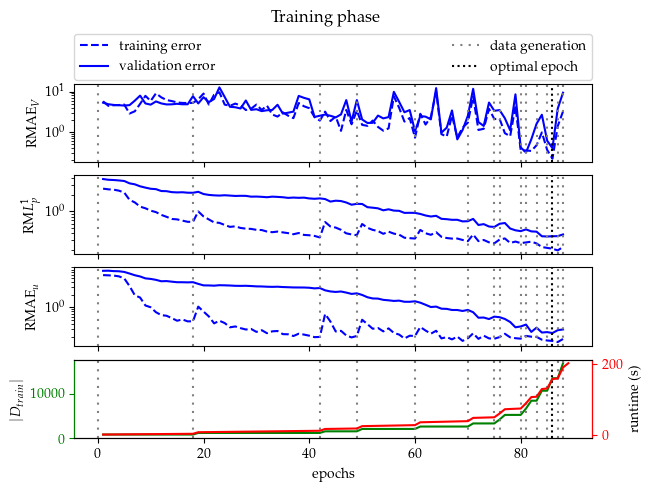

------------------------------------
 Training Statistics
------------------------------------
total training time:           201.501532
total number of training data: 16870

data generation occured at epochs 18, 42, 49, 60, 70, 75, 76, 80, 81, 83, 85, 87 with ratio 1.250000, 1.249562, 1.249502, 1.249756, 1.250000, 1.249772, 1.249940, 1.249856, 1.250000, 1.249970, 1.249953, 1.249944
total epochs: 88, optimal epoch: 86

training errors of optimal model:
value RMAE: 0.214580, grad RML1: 0.209969, ctrl RMAE: 0.157215
validation errors of optimal model:
value RMAE: 0.392949, grad RML1: 0.353175, ctrl RMAE: 0.242650



In [9]:
# plot errors, data set size and runtime in training phase
training.plot_training_phase(save=True, problem_type=problem_type, model_type=model_type, train_type=train_type)

# display training statistics
training.display_stats(save=True, problem_type=problem_type, model_type=model_type, train_type=train_type)

### Testing  model

In [10]:
# choose number of trajectories in test set
num_test_samples = 10

# load optimal model parameters
model = NN.load_model(problem_type, model_type, train_type)

# generate test data using NN warm start
X0_samples = data_generation.sample_X0(problem, num_samples=num_test_samples)
print('------------------------------------\n Test Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', 
                                                       init_config={'model':model})
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'test')

# compute test accuracy
test_data = data_generation.OCPDataset(problem_type, 'test')
if training.batch_size == 'full':
    test_dataloader = DataLoader(test_data, batch_size=len(test_data))
else:
    test_dataloader = DataLoader(test_data, batch_size=training.batch_size, shuffle=True)
print('------------------------------------\n Test Statistics\n------------------------------------')
print('test errors of optimal model:')
training.test_errors = np.hstack((training.test_errors, training.validate(test_dataloader, problem, model)))
training.add_test_stats(problem_type=problem_type, model_type=model_type, train_type=train_type)

------------------------------------
 Test Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 10 generating 1757 data points (from 598 initially guessed points)
solution time:       8.892588 of which 3.750497 solving BVP
solution time per data point: 0.005061

------------------------------------
 Test Statistics
------------------------------------
test errors of optimal model:
value RMAE: 0.359869, grad RML1: 0.380185, ctrl RMAE: 0.252917


### Properties of data sets

In [11]:
# display properties of data sets
print('------------------------------------\n Training Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'train', save=True, model_type=model_type, train_type=train_type)

print('------------------------------------\n Validation Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'val', save=True, model_type=model_type, train_type=train_type)

print('------------------------------------\n Test Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'test', save=True, model_type=model_type, train_type=train_type)

------------------------------------
 Training Data Set
------------------------------------
number of trajectories: 96, number of data points: 16870

------------------------------------
 Validation Data Set
------------------------------------
number of trajectories: 5, number of data points: 790

------------------------------------
 Test Data Set
------------------------------------
number of trajectories: 10, number of data points: 1757



### Simulation of NN, BVP, LQR solutions and uncontrolled system for specific initial condition

In [12]:
# name specific initial condition
init_type = 'sin'

# choose specific initial condition
#initial_condition = OCP.zero
#initial_condition = OCP.quadratic
#initial_condition = OCP.polynomial
initial_condition = OCP.sin
#initial_condition = OCP.quadratic_cos

# option to multiply initial condition with factor (scale or flip sign)
scale_factor = 1.

specific_X0 = scale_factor * initial_condition(problem.Omega_mesh[1:-1]).reshape(-1,1)

# get target
Y = problem.target(problem.Omega_mesh[1:-1]).reshape(-1,1)

# decide on methods for comparison (bilinear control does not allow for LQR)
methods = ['NN', 'LQR', 'BVP', 'unctrl'] 
if problem.ctrl == 'bilin' and 'LQR' in methods:
    methods.remove('LQR')

In [13]:
import NN_evaluation
import LQR
import simulation

# compute closed-loop NN solution
if 'NN' in methods:
    t_NN, X_NN = NN_evaluation.get_trajectory(problem, model, specific_X0)
    V_NN, P_NN, U_NN = NN_evaluation.get_data(model, t_NN, X_NN, get_U=True, problem=problem)

# compute closed-loop LQR solution
if 'LQR' in methods:
    if problem.target == OCP.zero:
        LQ_problem = LQR.LQProblem(problem)
    else:
        LQ_problem = LQR.LQProblemNonzeroTarget(problem)
    t_LQR, X_LQR = LQ_problem.get_trajectory(specific_X0)
    V_LQR, P_LQR, U_LQR = LQ_problem.get_data(t_LQR, X_LQR)
    
# compute open-loop BVP solution
if 'BVP' in methods:
    print('------------------------------------\n Specific Example Data Generation\n------------------------------------') 
    solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
    t_BVP, X_aug_BVP, _, X_aug_funs = BVP.solve_BVP(problem, specific_X0, initialization='NN_warm_start',
                                            init_config={'model':model}, solver_config=solver_config)
    X_BVP, V_BVP, P_BVP, U_BVP = data_generation.split_data(X_aug_BVP, get_U=True, problem=problem)
    
# compute uncontrolled dynamics 
if 'unctrl' in methods:
    ctrl = problem.ctrl
    problem.ctrl = None  
    print('--- Uncontrolled System ---')
    init_config = {'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}
    solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
    t_unctrl, X_aug_unctrl, _, _ = BVP.solve_BVP(problem, specific_X0, initialization='time_marching', 
                                                 init_config=init_config, solver_config=solver_config)
    X_unctrl, V_unctrl, P_unctrl, U_unctrl = data_generation.split_data(X_aug_unctrl, get_U=True, problem=problem)
    if not len(t_unctrl):
        methods.remove('unctrl')
    problem.ctrl = ctrl

------------------------------------
 Specific Example Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 99 data points (from 55 initially guessed points)
solution time:       0.741109 of which 0.215073 solving BVP
solution time per data point: 0.007486

--- Uncontrolled System ---


/home/eg/Desktop/Masterarbeit/programs/OCP.py:120: RuntimeWarning: overflow encountered in square
  R = self.b*X**2
/home/eg/Desktop/Masterarbeit/programs/OCP.py:200: RuntimeWarning: overflow encountered in multiply
  dRdx = 2*self.b*P*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:153: RuntimeWarning: overflow encountered in square
  return self.alpha*self.mesh_size*np.sum((X-Y)**2, axis=0, keepdims=True)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:312: RuntimeWarning: overflow encountered in multiply
  4 * f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:40: RuntimeWarning: invalid value encountered in subtract
  df_dy[:, i, :] = (f_new - f0) / hi


number of fails:     1
fail time:           8.465626

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    



/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:566: RuntimeWarning: invalid value encountered in true_divide
  r_middle /= 1 + np.abs(f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:567: RuntimeWarning: invalid value encountered in true_divide
  r1 /= 1 + np.abs(f1)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:568: RuntimeWarning: invalid value encountered in true_divide
  r2 /= 1 + np.abs(f2)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:115: RuntimeWarning: A singular Jacobian encountered when solving the collocation system.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


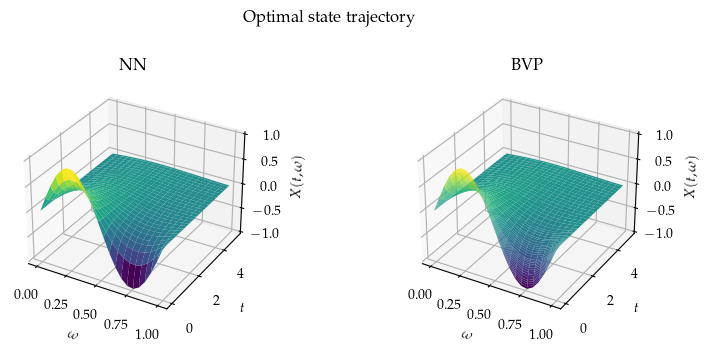

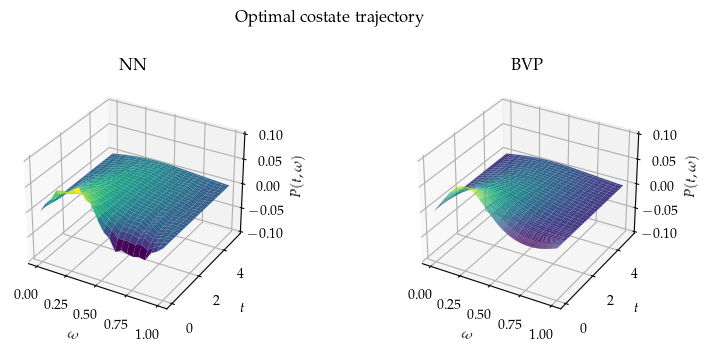

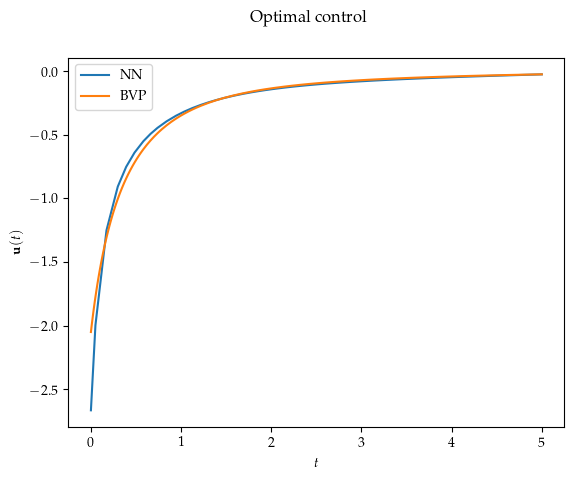

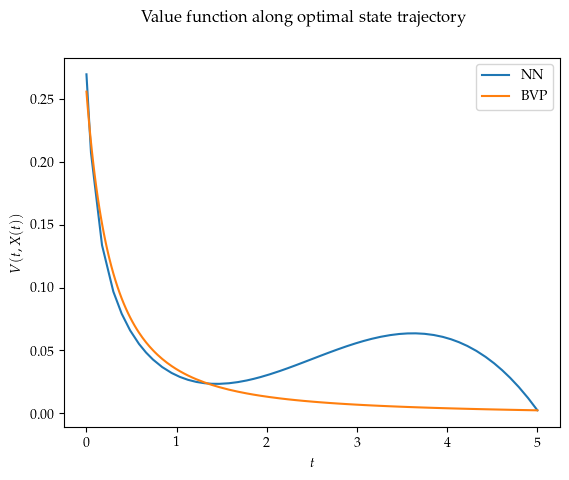

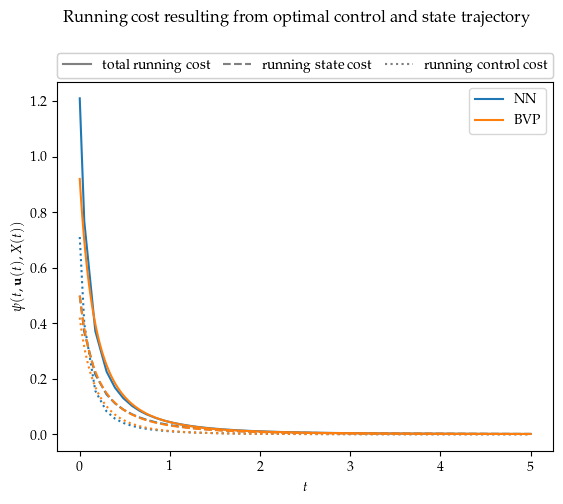

------------------------------------
 Costs of NN Solution
------------------------------------
running state cost:   0.157299
running control cost: 0.105664
total running cost:   0.262963
final cost:           0.002483
total cost:           0.265446

------------------------------------
 Costs of BVP Solution
------------------------------------
running state cost:   0.156433
running control cost: 0.097008
total running cost:   0.253441
final cost:           0.002433
total cost:           0.255874



In [14]:
# create directory for saving results
directory = simulation.get_directory(problem_type, model_type, train_type, init_type)

# plot optimal state trajectory
fig = plt.figure()
fig.suptitle('Optimal state trajectory', y=0.9)
axs = []
for num, method in enumerate(methods):                         
    axs.append(fig.add_subplot(1, len(methods), num + 1, projection='3d'))
    simulation.plot_X(eval('t_' + method), problem.Omega_mesh, eval('X_' + method), ax=axs[num])
    axs[num].set_title(method)
    axs[num].set_zlim(-1.,1.)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/state.png', bbox_inches='tight')
plt.show()

# plot optimal costate trajectory
fig = plt.figure()
fig.suptitle('Optimal costate trajectory', y=0.9)
axs = []
for num, method in enumerate(methods):                         
    axs.append(fig.add_subplot(1, len(methods), num + 1, projection='3d'))
    simulation.plot_P(eval('t_' + method), problem.Omega_mesh, eval('P_' + method), ax=axs[num])
    axs[num].set_title(method)
    axs[num].set_zlim(-0.1,0.1)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/costate.png', bbox_inches='tight')
plt.show()

# plot optimal control
fig = plt.figure()
fig.suptitle('Optimal control')
for method in methods:                         
    simulation.plot_U(eval('t_' + method), eval('U_' + method), label=method)
#plt.ylim(bottom=-5)
plt.legend()
plt.savefig(directory + '/control.png')
plt.show()

# plot value function along optimal state trajectory 
fig = plt.figure()
fig.suptitle('Value function along optimal state trajectory')
for method in methods:                         
    simulation.plot_V(eval('t_' + method), eval('V_' + method), label=method)
#plt.ylim(top=2.5)
plt.legend()
plt.savefig(directory + '/value_function.png')
plt.show()

# plot running cost resulting from optimal control and state trajectory 
fig = plt.figure()
fig.suptitle('Running cost resulting from optimal control and state trajectory', y=1.03)
for num, method in enumerate(methods):                         
    simulation.plot_running_cost(problem, eval('t_' + method), eval('U_' + method), eval('X_' + method), Y, 
                                 color='C' + str(num), label=method)
#plt.ylim(-1,5)
legend = plt.legend()
solid_line, = plt.plot([0],linestyle='-', color='gray')
dashed_line, = plt.plot([0],linestyle='--', color='gray')
dotted_line, = plt.plot([0],linestyle=':', color='gray')
legend_lines = plt.legend([solid_line, dashed_line, dotted_line], ['total running cost', 'running state cost', 'running control cost'], 
                          bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left', mode='expand', borderaxespad=0, ncol=3)
plt.gca().add_artist(legend)
plt.gca().add_artist(legend_lines)
plt.savefig(directory + '/running_cost.png')
plt.show()

# display costs
for num, method in enumerate(methods): 
    append = False if num == 0 else True
    simulation.display_costs(problem, eval('t_' + method), eval('U_' + method), eval('X_' + method), Y, 
                             method=method, save=True, append=append, 
                             problem_type=problem_type, model_type=model_type, train_type=train_type, init_type=init_type)

### Testing BVP initialization for data generation

In [15]:
# sample initial conditions
X0_samples = data_generation.sample_X0(problem, num_samples=100)
solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}

# test simple initialization
print('------------------------------------\n Simple Initialization\n------------------------------------')
_ = BVP.solve_BVP(problem, X0_samples, solver_config=solver_config)
#print('\n--- Increased time steps ---')
#_ = BVP.solve_BVP(problem, X0_samples, init_config={'timesteps':100}, solver_config=solver_config)

# test time-marching
print('------------------------------------\n Time-Marching\n------------------------------------')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', solver_config=solver_config)
print('\n--- Adaptive time sequence ---')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                  init_config={'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}, 
                  solver_config=solver_config)
print('\n--- Equidistant time sequences with increased time steps ---')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                  init_config={'timeseq':30}, solver_config=solver_config)
#print('\n--- Equidistant time sequences with decreased time steps ---')
#_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
#                  init_config={'timeseq':5}, solver_config=solver_config)

# test NN warm start
print('------------------------------------\n NN Warm Start\n------------------------------------') 
_ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', 
                  init_config={'model':model}, solver_config=solver_config)

# test NN warm start with partially trained models
for partial_train_time in partial_train_times[:-1]:
    partial_train_type = train_type + 'PartialTrain' + str(partial_train_time)
    directory = NN.get_directory(problem_type, model_type, partial_train_type, make=False)
    if os.path.exists(directory):
        print(f'\n--- Partially trained model after time {partial_train_time} ---')
        partial_train_model = NN.load_model(problem_type, model_type, partial_train_type)
        _ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', init_config={'model':partial_train_model}, solver_config=solver_config)

------------------------------------
 Simple Initialization
------------------------------------


/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/OCP.py:157: RuntimeWarning: overflow encountered in square
  return self.beta*U**2
/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: A singular Jacobian encountered when solving the collocation system.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/OCP.py:187: RuntimeWarning: overflow encountered in matmul
  U = -self.c/(2*self.beta) * np.diag(P.T @ X).reshape((1,-1))
/home/eg/Desktop/Masterarbeit/programs/OCP.py:187: RuntimeWarning: invalid value encountered in matmul
  U = -self.c/(2*self.beta) * np.diag(P.T @ X).reshape((1,-1))
/home/eg/Desktop/Masterarbeit/programs/OCP.py:130: RuntimeWarning: overflow encountered in multiply
  S = self.c*U*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:132: RuntimeWarning: invalid value encountered in

number of fails:     42
fail time:           378.607312

number of solutions: 58 generating 27455 data points (from 1740 initially guessed points)
solution time:       81.430612 of which 81.424336 solving BVP
solution time per data point: 0.002966

------------------------------------
 Time-Marching
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 100 generating 15767 data points (from 14855 initially guessed points)
solution time:       105.915011 of which 17.827461 solving BVP
solution time per data point: 0.006718


--- Adaptive time sequence ---
number of fails:     0
fail time:           0.000000

number of solutions: 100 generating 15985 data points (from 15179 initially guessed points)
solution time:       106.974190 of which 18.591926 solving BVP
solution time per data point: 0.006692


--- Equidistant time sequences with increased time steps ---
number of fails:     0
fail time:           0.000000

number of soluti